In [12]:
import os, shutil
# point to the Program Files Graphviz dot.exe you validated
os.environ['GRAPHVIZ_DOT'] = r"C:\Program Files\Graphviz\bin\dot.exe"

# Optional: ensure the process PATH prefers the same Graphviz bin directory
gv_bin = r"C:\Program Files\Graphviz\bin"
os.environ['PATH'] = gv_bin + os.pathsep + os.environ.get('PATH', '')

# Sanity checks
print("GRAPHVIZ_DOT:", os.environ.get('GRAPHVIZ_DOT'))
print("shutil.which('dot') ->", shutil.which('dot'))

GRAPHVIZ_DOT: C:\Program Files\Graphviz\bin\dot.exe
shutil.which('dot') -> /home/asen/anaconda3/envs/measles-threshold/bin/dot


In [13]:
import pymc as pm 
import arviz as az 
import pandas as pd 
import numpy as np
import pytensor.tensor as pt
import graphviz

In [14]:
df = pd.read_csv('../data/processed/vax_pop_merged.csv')
df.columns

Index(['fips', 'county_x', 'state_x', 'mmr_coverage', 'year', 'count',
       'had_cases', 'state_fips', 'county_fips', 'state_y', 'county_y',
       'population', 'pop_under5', 'pop_5to13', 'pop_14to17', 'pop_18to24',
       'pop_25to44', 'pop_45to64', 'pop_65plus', 'area_sqkm', 'area_sqmi',
       'pop_density'],
      dtype='object')

Derive IDs and z-scored covariates: 

In [15]:
df['state_id'] = df['state_x'].astype('category').cat.codes
df['year'] = df['year'].astype('category').cat.codes 

age_cols = [c for c in df.columns if c.startswith('pop_')]

def zscore(x): 
    mu, sd = np.nanmean(x), np.nanstd(x)
    if sd == 0 or np.isnan(sd):
        return np.zeros_like(x, dtype=float)
    return (x - mu) / sd

# For pop density, log1p then z-score
df['log_pop_density'] = zscore(np.log1p(df['pop_density']))
for col in age_cols:
    df[f'z_{col}'] = zscore(df[col])

# Final list of covariates
X_cols = ['log_pop_density'] + [f'z_{c}' for c in age_cols]
X_cols

['log_pop_density',
 'z_pop_under5',
 'z_pop_5to13',
 'z_pop_14to17',
 'z_pop_18to24',
 'z_pop_25to44',
 'z_pop_45to64',
 'z_pop_65plus',
 'z_pop_density']

Build model arrays: 

In [19]:
# Core arrays
state_idx = df['state_id'].to_numpy()
year_idx = df['year'].to_numpy()
pop = df['population'].to_numpy(dtype=float)
mmr = df['mmr_coverage'].to_numpy(dtype=float)
y_obs = df['count'].to_numpy(dtype=int)

# Covariate matrix
X = df[X_cols].to_numpy(dtype=float) 

S = df['state_id'].nunique()
T = df['year'].nunique()
N = len(y_obs)
P = X.shape[1]

states = df['state_x'].astype('category').cat.categories.tolist()
years = sorted(df['year'].unique().tolist())

# Epidemiological constants
VE = 0.97           # Vaccine efficacy
gamma = 1.0/7.0     # Recovery rate (1/duration of infectiousness)
eps = 1e-6          # Small constant to avoid log(0)  

len(y_obs), S, T, X.shape

(17337, 39, 8, (17337, 9))

Specify the PyMC model (transmission --> $R_0$ --> $p_c$)

In [20]:
with pm.Model(coords={'obs': np.arange(N), 'state': np.arange(S), 'year': np.arange(T), 'feature': np.arange(P)}) as bhm: 
    state_i = pm.Data("state_i", state_idx, dims="obs")
    year_i  = pm.Data("year_i",  year_idx,  dims="obs")
    X_      = pm.Data("X", X, dims=("obs","feature"))
    pop_    = pm.Data("pop", pop, dims="obs")
    mmr_    = pm.Data("mmr", mmr, dims="obs")

    # Hierarchy on baseline transmission (NON-CENTERED) 
    mu_log_beta0 = pm.Normal("mu_log_beta0", 0, 1)
    sd_log_beta0 = pm.HalfNormal("sd_log_beta0", 1.0)

    z_state = pm.Normal("z_state", 0, 1, dims="state")
    log_beta0_state = pm.Deterministic(
        "log_beta0_state", mu_log_beta0 + z_state * sd_log_beta0, dims="state"
    )
    beta0_state = pm.Deterministic("beta0_state", pt.exp(log_beta0_state), dims="state")

    # Derived R0 and pc
    R0_state    = pm.Deterministic("R0_state", beta0_state / gamma, dims="state")
    pc_state    = pm.Deterministic("pc_state", 1.0 - (1.0 / R0_state), dims="state")
    R0_overall  = pm.Deterministic("R0_overall", pt.exp(mu_log_beta0) / gamma)
    pc_overall  = pm.Deterministic("pc_overall", 1.0 - (1.0 / R0_overall))

    # Random intercepts (NON-CENTERED for state & year)
    mu_alpha = pm.Normal("mu_alpha", 0.0, 2.0)
    sd_alpha = pm.HalfNormal("sd_alpha", 1.0)
    z_alpha  = pm.Normal("z_alpha", 0, 1, dims="state")
    alpha_state = pm.Deterministic(
        "alpha_state", mu_alpha + z_alpha * sd_alpha, dims="state"
    )

    sd_year  = pm.HalfNormal("sd_year", 1.0)
    z_year   = pm.Normal("z_year", 0, 1, dims="year")
    delta_year = pm.Deterministic("delta_year", z_year * sd_year, dims="year")

    # Additive covariates 
    beta = pm.Normal("beta", 0.0, 1.0, dims="feature")

    # Effective transmission and Re per observation 
    # guard against tiny negatives from numeric issues
    susceptible_frac = 1.0 - pt.clip(VE * mmr_, 0, 0.999)
    beta0_at_obs = beta0_state[state_i]
    Re = pm.Deterministic("Re", (beta0_at_obs * susceptible_frac) / gamma, dims="obs")
    log_Re = pt.log(Re)

    # Strength of Re --> incidence 
    kappa = pm.Normal("kappa", 1.0, 0.5)

    # Linear predictor & mean 
    linpred = (
        alpha_state[state_i]
        + delta_year[year_i]
        + kappa * log_Re
        + (X_ @ beta)
    )
    mu = pt.exp(pt.log(pop_) + linpred)

    # Likelihood 
    # NB parameterization: mu + alpha (overdispersion)
    phi = pm.Gamma("phi", alpha=2.0, beta=0.1)  # tune as appropriate
    y = pm.NegativeBinomial("y", mu=mu, alpha=phi, observed=y_obs, dims="obs")

In [21]:
import pymc as pm
# rebuild or reopen your model object `bhm` if needed, then:
gv = pm.model_to_graphviz(bhm)
print(type(gv))
print(gv.source[:800])
png = gv.pipe(format='png')
print("Rendered bytes:", len(png))

<class 'graphviz.dot.Digraph'>
digraph {
	subgraph "clusterobs (17337)" {
		mmr [label="mmr
~
Data" shape=box style="rounded, filled"]
		state_i [label="state_i
~
Data" shape=box style="rounded, filled"]
		y [label="y
~
NegBinomial" shape=ellipse style=filled]
		pop [label="pop
~
Data" shape=box style="rounded, filled"]
		Re [label="Re
~
Deterministic" shape=box]
		year_i [label="year_i
~
Data" shape=box style="rounded, filled"]
		label="obs (17337)" labeljust=r labelloc=b style=rounded
	}
	subgraph "clusterobs (17337) x feature (9)" {
		X [label="X
~
Data" shape=box style="rounded, filled"]
		label="obs (17337) x feature (9)" labeljust=r labelloc=b style=rounded
	}
	sd_alpha [label="sd_alpha
~
HalfNormal" shape=ellipse]
	mu_log_beta0 [label="mu_log_beta0
~
Normal" shape=ellipse]
	sd_year [label="sd_year
~
HalfNormal" s
Rendered bytes: 196267


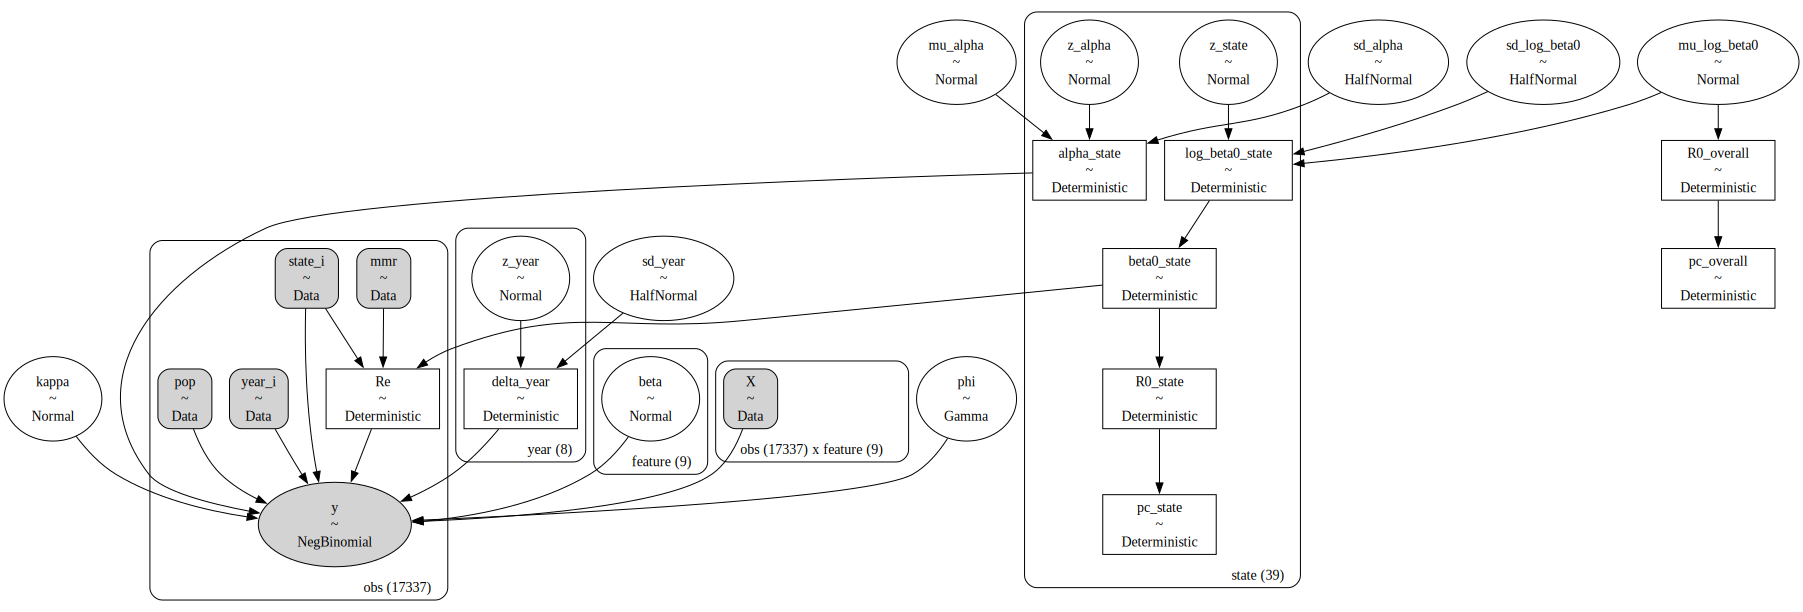

In [22]:
pm.model_to_graphviz(bhm)

In [23]:
# run in notebook (fresh kernel state)
print("N observations:", len(y_obs))
print("Covariate matrix shape:", X.shape)
print("states (S):", S, "years (T):", T)
print("Number of model free random variables:", len(bhm.free_RVs))
print("List of free RV names:", [v.name for v in bhm.free_RVs])

N observations: 17337
Covariate matrix shape: (17337, 9)
states (S): 39 years (T): 8
Number of model free random variables: 11
List of free RV names: ['mu_log_beta0', 'sd_log_beta0', 'z_state', 'mu_alpha', 'sd_alpha', 'z_alpha', 'sd_year', 'z_year', 'beta', 'kappa', 'phi']


In [24]:
# small trial run to test sampler behavior
with bhm:
    idata_small = pm.sample(draws=200, tune=200, chains=1, cores=1, progressbar=True, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_log_beta0, sd_log_beta0, z_state, mu_alpha, sd_alpha, z_alpha, sd_year, z_year, beta, kappa, phi]


/home/asen/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 1 chain for 200 tune and 200 draw iterations (200 + 200 draws total) took 81 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Short smoke test: 

In [25]:
with bhm: 
    idata_test = pm.sample(500, tune=500, chains=2, target_accept=0.9, progressbar=True)
az.summary(idata_test, var_names=['mu_log_beta0', 'sd_log_beta0', 'phi', 'kappa'])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_log_beta0, sd_log_beta0, z_state, mu_alpha, sd_alpha, z_alpha, sd_year, z_year, beta, kappa, phi]


/home/asen/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 199 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_log_beta0,-3.706,0.746,-5.107,-2.381,0.020,0.022,1359.0,777.0,1.00
sd_log_beta0,0.480,0.259,0.001,0.851,0.027,0.008,97.0,247.0,1.01
phi,0.057,0.006,0.046,0.070,0.000,0.000,2369.0,851.0,1.00
kappa,1.753,0.218,1.328,2.131,0.005,0.007,1810.0,814.0,1.00


Real sampling run: 

In [26]:
with bhm:
    idata = pm.sample(
        draws=2000,
        tune=2000,
        chains=4,
        target_accept=0.98,
        max_treedepth=15,
        progressbar=True,
    )


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log_beta0, sd_log_beta0, z_state, mu_alpha, sd_alpha, z_alpha, sd_year, z_year, beta, kappa, phi]


/home/asen/.local/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" for Jupyter 
support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1503 seconds.
